## Binary Segmentation Model (Fruit vs. Background)

imports

In [1]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

Making sure that both sets have the same fruit types

In [2]:
trainFruits=os.listdir('Project Data/Fruit/Train')
testFruits=os.listdir('Project Data/Fruit/Validation')

In [3]:
assert set(trainFruits) == set(testFruits), "Train and Test folders must have the same fruit categories"

### Read all the filenames first to shuffle them before generating a batch

In [4]:
fruits = trainFruits  
all_file_pairs = []

for fruit in fruits:
    image_dir = f'Project Data/Fruit/Train/{fruit}/Images'
    mask_dir = f'Project Data/Fruit/Train/{fruit}/Mask'
    
    filenames = os.listdir(image_dir)
    
    for filename in filenames:
        img_path = os.path.join(image_dir, filename)
        
        mask_filename = f"{filename.split('.')[0]}_mask.png"
        mask_path = os.path.join(mask_dir, mask_filename)
        
        all_file_pairs.append((img_path, mask_path))

random.shuffle(all_file_pairs)

Size of the dataset

In [5]:
len(all_file_pairs)

1759

Helper function

In [6]:
def read_and_process_image(path,size=(224,224)):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    image = image / 255.0
    return image

In [ ]:
def read_and_process_mask(path, fruitID,size=(224,224)):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, size,interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.int32) #convert to 0 or 1
    mask = mask * fruitID #assign fruitID to the fruit pixels, so the picture becomes 0 or fruitID
    mask = np.expand_dims(mask, axis=-1)
    return mask

### Create a mapping of fruit names to unique IDs

In [8]:
class_map = {fruit_name: i+1 for i, fruit_name in enumerate(sorted(fruits))}
class_map['background'] = 0

Batch generator

In [ ]:
def get_batch(file_pairs, batch_size):
    L = len(file_pairs)
    random.shuffle(file_pairs) # shuffle each epoch
    
    for start in range(0, L, batch_size):
        end = min(start + batch_size, L)
        current_batch_pairs = file_pairs[start:end]
        
        x_batch = []
        y_batch = []
        
        for img_p, mask_p in current_batch_pairs:
            img = read_and_process_image(img_p)
            x_batch.append(img)
            
            mask = read_and_process_mask(mask_p,fruitID=class_map[img_p.split('/')[3]]) # extract fruit name(the class ID) from path
            y_batch.append(mask)
        
        yield np.array(x_batch), np.array(y_batch)

### Plot a batch of images and masks

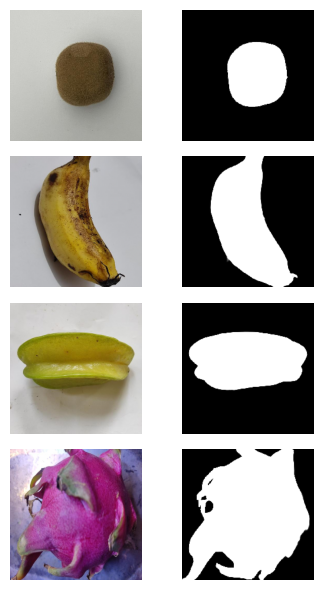

In [11]:
for x, y in get_batch(all_file_pairs, 4):
    
    plt.figure(figsize=(4,6))
    
    for i in range(len(x)):
        
        plt.subplot(len(x), 2, 2*i + 1)
        plt.imshow(x[i])
        plt.axis("off")
        
        plt.subplot(len(x), 2, 2*i + 2)
        plt.imshow(y[i].squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()
    
    break

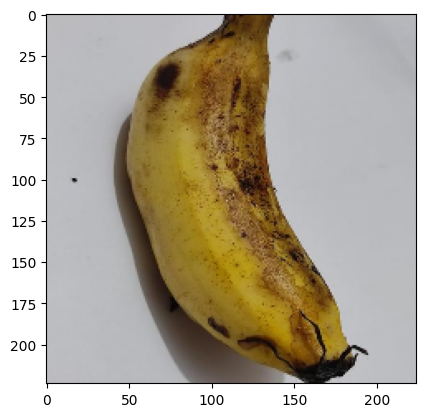

In [12]:
plt.imshow(x[1].squeeze())

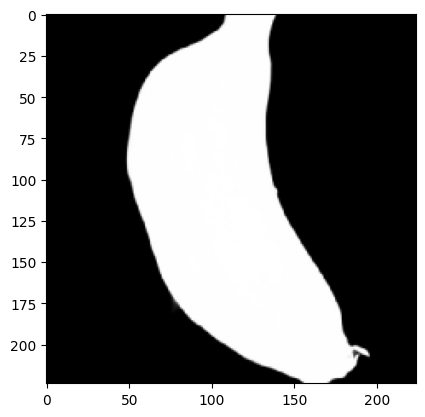

In [13]:
plt.imshow(y[1].squeeze(),cmap='gray')

### Chose a pixel from the banana body to ensure it has the correct class ID

In [14]:
y[1,121,120]

array([4.])

it is indeed 4 as its supposed to be

In [16]:
class_map['Banana']

4

### For clarification :
* the X (model input) is still the same (the image)
* the Y (model output) is now a mask with multiple classes (0 for background, 1 for apple, 2 for banana, etc.)

we can do this instead of one-hot encoding the masks and creating a 224x224x31 tensor , which consumes more memory.